# Pseudotime analyis

In [40]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

In [41]:
Path='/home/mgander/pancreas_multiome/data2'
adata=sc.read_h5ad(f'{Path}/Lung_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 88729 × 3000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2', 'level_3', 'sort_batch', 'Cell_type', 'n_counts', 'batch', 'publication', 'sample_name', 'tissue', 'derive', 'detail_tissue', 'time', 'time2', 'main_cells', 'protocol', 'tech', 'tech_detail', 'molecular', 'gel', 'conditions_combined', 'day', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'derive_colors', 'hvg', 'leiden', 'leiden_colors', 'level_1_colors', 'level_2_colors', 'neighbors', 'umap'
    obsm: 'X_scPoli', 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# Pseudotime analysis

In [42]:
sc.tl.diffmap(adata)

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


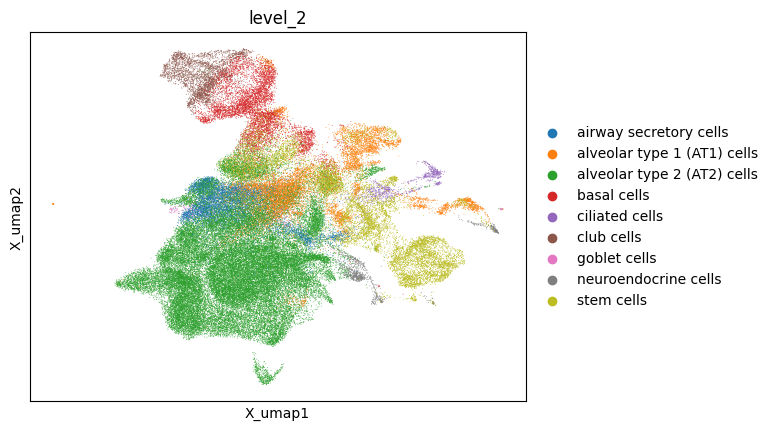

In [51]:
sc.pl.embedding(adata, basis='X_umap', color='level_2')

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


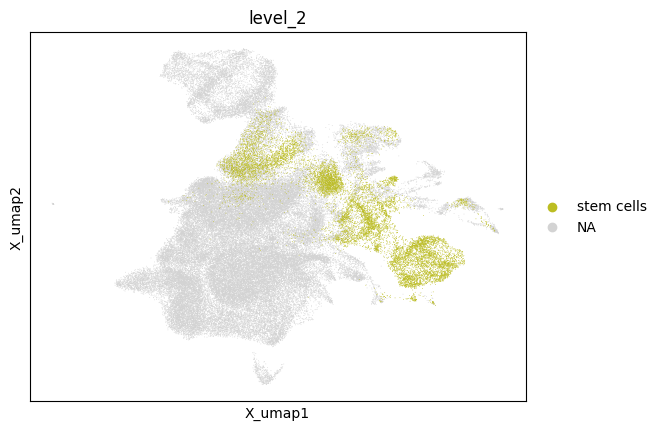

In [43]:
sc.pl.embedding(adata, basis='X_umap', color='level_2', groups=['stem cells'])

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


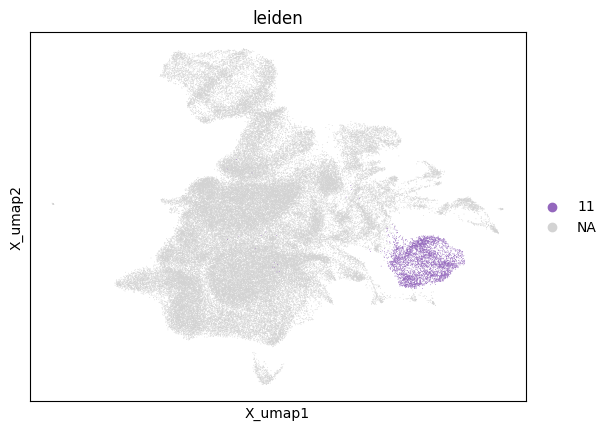

In [118]:
sc.pl.embedding(adata, basis='X_umap', color='leiden', groups=['11'])

In [129]:
adata.obs.columns

Index(['initial_size_spliced', 'initial_size_unspliced', 'initial_size',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2',
       'level_3', 'sort_batch', 'Cell_type', 'n_counts', 'batch',
       'publication', 'sample_name', 'tissue', 'derive', 'detail_tissue',
       'time', 'time2', 'main_cells', 'protocol', 'tech', 'tech_detail',
       'molecular', 'gel', 'conditions_combined', 'day', 'leiden', 'root',
       'dpt_pseudotime'],
      dtype='object')

In [44]:
# let's pick some random stem cells

In [45]:
n=10
inds=np.random.choice(list(adata.obs[(adata.obs['level_2']=='stem cells')&(adata.obs['day']==0)].index), n, replace=False)

In [119]:
inds=np.random.choice(list(adata.obs[(adata.obs['level_2']=='stem cells')&(adata.obs['leiden']=='11')].index), n, replace=False)

In [120]:
ii=np.where([a in inds for a in adata.obs.index])[0]

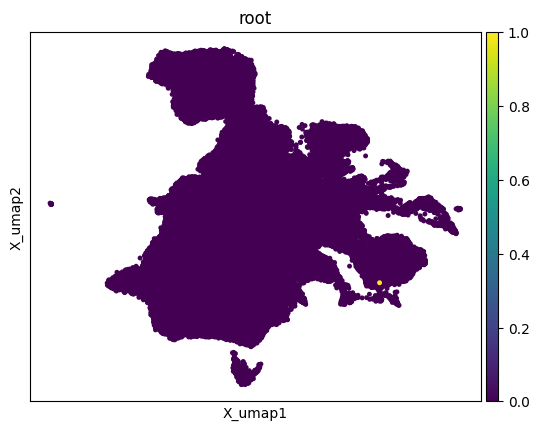

In [121]:
# Let's pick a root cell
i=ii[0]
z=np.zeros(len(adata))
z[i]=1
adata.obs['root']=z
sc.pl.embedding(adata, basis='X_umap', color='root', s=50)
adata.uns['iroot'] = i

In [122]:
sc.tl.dpt(adata)

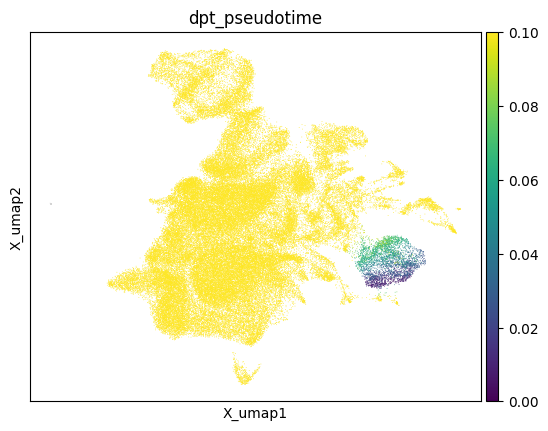

In [126]:
sc.pl.embedding(adata, basis='X_umap', color='dpt_pseudotime', color_map='viridis', vmax=0.1)

# Cellrank analysis

In [137]:
pk = cr.kernels.PseudotimeKernel(adata, time_key='dpt_pseudotime')

In [138]:
# Doesnt work for some root states, since matrix isn't row stochastic (it's because neighbor graph is corrupted,
# because of subsampling and not recomputing neighbor graph)
pk.compute_transition_matrix()

  0%|          | 0/88729 [00:00<?, ?cell/s]

PseudotimeKernel[n=88729, dnorm=False, scheme='hard', frac_to_keep=0.3]

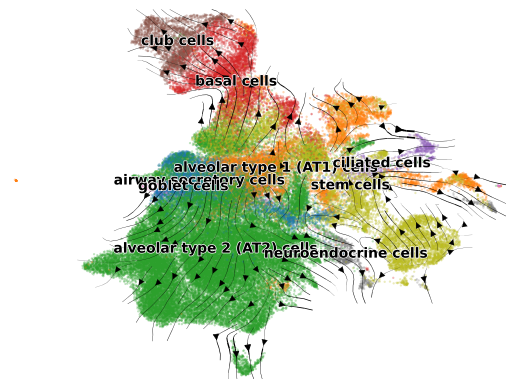

In [139]:
pk.plot_projection(basis='X_umap', color="level_2", recompute=True, 
                   connectivities=adata.obsp['connectivities'], title='')

In [140]:
T=pk.transition_matrix

In [141]:
import pickle
with open(f'{Path}/dpt_lung.pkl', 'wb') as handle:
    pickle.dump(T, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [142]:
pseudotime=adata.obs[['dpt_pseudotime']]

In [143]:
pseudotime.to_pickle(f'{Path}/dpt_lung.pkl')